## Step 1: Environment Setup Using `uv`

We’ll use [**`uv`**](https://github.com/astral-sh/uv)—a fast Python package manager—for blazing fast environment setup.

### 1.1 Create and Activate Virtual Environment

```
uv venv rag-env
source rag-env/bin/activate

```

This creates a virtual environment named `rag-env` and activates it.

---

### 1.2 Install Required Packages

Now install the core dependencies for this RAG Agent:

```
uv pip install \
    langchain \
    langgraph \
    langchain-google-genai \
    langchain-community \
    python-dotenv \
    jupyterlab \
    ipykernel

```

---

### 1.3 Register Virtual Environment with Jupyter

To make your `rag-env` available as a Jupyter kernel:

```
python -m ipykernel install --user --name=rag-env --display-name "RAG Agent (uv)"

```

Now you can select **RAG Agent (uv)** as the kernel in Jupyter Notebook or JupyterLab.

## Environment Setup and Dependencies

In [22]:
from dotenv import load_dotenv
load_dotenv()

# Core LangChain components
from langchain.schema import Document
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate

# Graph and state management
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


**Technology Stack Rationale:**

- **Google Gemini**: Advanced reasoning capabilities for complex query understanding
- **HuggingFace Embeddings**: High-quality, cost-effective embedding generation
- **Chroma Vector DB**: Lightweight, fast vector storage for development
- **LangGraph**: Enables sophisticated workflow orchestration with state management
- **Pydantic**: Ensures structured, validated outputs from LLM operations

## Building Our Knowledge Base

Let's create a comprehensive technology support knowledge base for "TechFlow Solutions":

In [23]:
# Initialize our embedding model
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Create comprehensive technology support knowledge base
knowledge_documents = [
    Document(
        page_content="TechFlow Solutions offers three main service tiers: Basic Support ($29/month) includes email support and basic troubleshooting, Professional Support ($79/month) includes priority phone support and advanced diagnostics, Enterprise Support ($199/month) includes 24/7 dedicated support and custom integrations.",
        metadata={"source": "pricing_guide.pdf", "category": "pricing"},
    ),
    Document(
        page_content="Our cloud infrastructure services include: Virtual Private Servers starting at $15/month, Managed Databases from $45/month, Content Delivery Network at $0.08/GB, and Load Balancing services at $25/month. All services include 99.9% uptime guarantee.",
        metadata={"source": "infrastructure_pricing.pdf", "category": "services"},
    ),
    Document(
        page_content="TechFlow Solutions was founded in 2018 by Maria Rodriguez, a former Google engineer with 15 years of experience in cloud architecture. The company has grown from 3 employees to over 150 team members across 12 countries, specializing in enterprise cloud solutions.",
        metadata={"source": "company_history.pdf", "category": "company"},
    ),
    Document(
        page_content="Our technical support team operates 24/7 for Enterprise customers, business hours (9 AM - 6 PM EST) for Professional customers, and email-only support for Basic customers. Average response times: Enterprise (15 minutes), Professional (2 hours), Basic (24 hours).",
        metadata={"source": "support_procedures.pdf", "category": "support"},
    )
]

# Build vector database
vector_store = Chroma.from_documents(knowledge_documents, embedding_model)
document_retriever = vector_store.as_retriever(search_kwargs={"k": 2})


## State Management System

Our agent uses sophisticated state management to track conversation flow:

In [24]:
class ConversationState(TypedDict):
    conversation_history: List[BaseMessage]  # Full conversation thread
    retrieved_documents: List[Document]      # Current retrieved documents
    topic_relevance: str                     # On-topic or off-topic classification
    enhanced_query: str                      # Reformulated question
    should_generate: bool                    # Whether to proceed with answer generation
    optimization_attempts: int              # Number of query refinement attempts
    current_query: HumanMessage             # User's current question


## Core Agent Components

### 1. Query Enhancer - Intelligent Question Reformulation

In [25]:
def enhance_user_query(state: ConversationState):
    """
    Reformulates user questions based on conversation history to create
    standalone queries optimized for vector search.
    """
    print(f" Enhancing query: {state['current_query'].content}")

    # Initialize state for new query processing
    state["retrieved_documents"] = []
    state["topic_relevance"] = ""
    state["enhanced_query"] = ""
    state["should_generate"] = False
    state["optimization_attempts"] = 0

    # Ensure conversation history exists
    if "conversation_history" not in state or state["conversation_history"] is None:
        state["conversation_history"] = []

    # Add current query to history if not already present
    if state["current_query"] not in state["conversation_history"]:
        state["conversation_history"].append(state["current_query"])

    # Check if we have conversation context
    if len(state["conversation_history"]) > 1:
        # Extract context and current question
        previous_messages = state["conversation_history"][:-1]
        current_question = state["current_query"].content

        # Build context-aware prompt
        context_messages = [
            SystemMessage(
                content="""You are an expert query reformulator. Transform the user's question into a standalone,
                search-optimized query that incorporates relevant context from the conversation history.

                Guidelines:
                - Make the question self-contained and clear
                - Preserve the user's intent while adding necessary context
                - Optimize for vector database retrieval
                - Keep the reformulated query concise but comprehensive"""
            )
        ]
        context_messages.extend(previous_messages)
        context_messages.append(HumanMessage(content=f"Current question: {current_question}"))

        # Generate enhanced query
        enhancement_prompt = ChatPromptTemplate.from_messages(context_messages)
        llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.1)

        formatted_prompt = enhancement_prompt.format()
        response = llm.invoke(formatted_prompt)
        enhanced_question = response.content.strip()

        print(f" Enhanced query: {enhanced_question}")
        state["enhanced_query"] = enhanced_question
    else:
        # First question in conversation - use as-is
        state["enhanced_query"] = state["current_query"].content
        print(f"First query - using original: {state['enhanced_query']}")

    return state


### 2. Topic Validator - Smart Domain Classification

In [26]:
class TopicRelevance(BaseModel):
    """Structured output for topic classification"""
    classification: str = Field(
        description="Is the question about TechFlow Solutions services/pricing/company? Answer 'RELEVANT' or 'IRRELEVANT'"
    )
    confidence: str = Field(
        description="Confidence level: 'HIGH', 'MEDIUM', or 'LOW'"
    )

def validate_topic_relevance(state: ConversationState):
    """
    Determines if the user's question is within our knowledge domain.
    Uses the enhanced query for better classification accuracy.
    """
    print("Validating topic relevance...")

    classification_prompt = SystemMessage(
        content="""You are a topic classifier for TechFlow Solutions support system.

        RELEVANT topics include:
        - TechFlow Solutions services (cloud infrastructure, migration, DevOps)
        - Pricing for any TechFlow Solutions products or services
        - Company information (history, team, locations)
        - Support procedures and response times
        - Security and compliance features
        - Technical specifications and capabilities

        IRRELEVANT topics include:
        - General technology questions not specific to TechFlow
        - Other companies' products or services
        - Personal questions unrelated to business
        - Weather, news, or general knowledge queries

        Classify based on the enhanced query which incorporates conversation context."""
    )

    user_question = HumanMessage(
        content=f"Enhanced query to classify: {state['enhanced_query']}"
    )

    # Create classification chain
    classification_chain = ChatPromptTemplate.from_messages([classification_prompt, user_question])
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)

    structured_llm = llm.with_structured_output(TopicRelevance)
    classifier = classification_chain | structured_llm

    result = classifier.invoke({})
    state["topic_relevance"] = result.classification.strip()

    print(f"Topic classification: {state['topic_relevance']} (Confidence: {result.confidence})")
    return state


### 3. Content Retriever - Intelligent Document Fetching

In [27]:
def fetch_relevant_content(state: ConversationState):
    """
    Retrieves documents from the knowledge base using the enhanced query.
    """
    print("Fetching relevant documents...")

    # Use enhanced query for better retrieval
    retrieved_docs = document_retriever.invoke(state["enhanced_query"])

    print(f"Retrieved {len(retrieved_docs)} documents")
    for i, doc in enumerate(retrieved_docs):
        print(f"   Document {i+1}: {doc.page_content[:50]}...")

    state["retrieved_documents"] = retrieved_docs
    return state


### 4. Relevance Assessor - Document Quality Control

In [28]:
class DocumentRelevance(BaseModel):
    """Structured output for document relevance assessment"""
    relevance: str = Field(
        description="Is this document relevant to answering the question? Answer 'RELEVANT' or 'IRRELEVANT'"
    )
    reasoning: str = Field(
        description="Brief explanation of why the document is relevant or irrelevant"
    )

def assess_document_relevance(state: ConversationState):
    """
    Evaluates each retrieved document to determine if it's relevant
    for answering the user's question.
    """
    print("Assessing document relevance...")

    assessment_prompt = SystemMessage(
        content="""You are a document relevance assessor. Evaluate whether each document
        contains information that can help answer the user's question.

        A document is RELEVANT if it contains:
        - Direct answers to the question
        - Supporting information that contributes to a complete answer
        - Context that helps understand the topic

        A document is IRRELEVANT if it:
        - Contains no information related to the question
        - Discusses completely different topics
        - Provides no value for answering the question

        Be strict but fair in your assessment."""
    )

    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0)
    structured_llm = llm.with_structured_output(DocumentRelevance)

    relevant_documents = []

    for i, doc in enumerate(state["retrieved_documents"]):
        assessment_query = HumanMessage(
            content=f"""Question: {state['enhanced_query']}

            Document to assess:
            {doc.page_content}

            Is this document relevant for answering the question?"""
        )

        assessment_chain = ChatPromptTemplate.from_messages([assessment_prompt, assessment_query])
        assessor = assessment_chain | structured_llm

        result = assessor.invoke({})

        print(f"📋 Document {i+1}: {result.relevance} - {result.reasoning}")

        if result.relevance.strip().upper() == "RELEVANT":
            relevant_documents.append(doc)

    # Update state with filtered documents
    state["retrieved_documents"] = relevant_documents
    state["should_generate"] = len(relevant_documents) > 0

    print(f"Final relevant documents: {len(relevant_documents)}")
    return state


### 5. Response Generator - Context-Aware Answer Creation

In [29]:
def generate_contextual_response(state: ConversationState):
    """
    Generates final response using conversation history and relevant documents.
    """
    print("Generating contextual response...")

    if "conversation_history" not in state or state["conversation_history"] is None:
        raise ValueError("Conversation history is required for response generation")

    # Extract components for response generation
    conversation_context = state["conversation_history"]
    relevant_docs = state["retrieved_documents"]
    enhanced_question = state["enhanced_query"]

    # Create comprehensive response template
    response_template = """You are a knowledgeable TechFlow Solutions support agent. Generate a helpful,
    accurate response based on the conversation history and retrieved documents.

    Guidelines:
    - Use information from the provided documents to answer the question
    - Maintain conversation context and refer to previous exchanges when relevant
    - Be conversational and helpful in tone
    - If the documents don't fully answer the question, acknowledge limitations
    - Provide specific details when available (prices, timeframes, etc.)

    Conversation History:
    {conversation_history}

    Retrieved Knowledge:
    {document_context}

    Current Question: {current_question}

    Generate a helpful response:"""

    response_prompt = ChatPromptTemplate.from_template(response_template)
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.3)

    # Create response generation chain
    response_chain = response_prompt | llm

    # Generate response
    response = response_chain.invoke({
        "conversation_history": conversation_context,
        "document_context": relevant_docs,
        "current_question": enhanced_question
    })

    generated_response = response.content.strip()

    # Add response to conversation history
    state["conversation_history"].append(AIMessage(content=generated_response))

    print(f" Generated response: {generated_response[:100]}...")
    return state


### 6. Query Optimizer - Adaptive Search Improvement

In [30]:
def optimize_search_query(state: ConversationState):
    """
    Refines the search query when initial retrieval doesn't yield relevant results.
    Includes loop prevention to avoid infinite optimization cycles.
    """
    print("Optimizing search query...")

    current_attempts = state.get("optimization_attempts", 0)

    # Prevent infinite optimization loops
    if current_attempts >= 2:
        print("Maximum optimization attempts reached")
        return state

    current_query = state["enhanced_query"]

    optimization_prompt = SystemMessage(
        content="""You are a search query optimizer. The current query didn't retrieve relevant documents.

        Create an improved version that:
        - Uses different keywords or synonyms
        - Adjusts the query structure for better matching
        - Maintains the original intent while improving searchability
        - Considers alternative ways to express the same concept

        Provide only the optimized query without explanations."""
    )

    optimization_request = HumanMessage(
        content=f"Current query that needs optimization: {current_query}"
    )

    optimization_chain = ChatPromptTemplate.from_messages([optimization_prompt, optimization_request])
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.2)

    formatted_prompt = optimization_chain.format()
    response = llm.invoke(formatted_prompt)
    optimized_query = response.content.strip()

    # Update state
    state["enhanced_query"] = optimized_query
    state["optimization_attempts"] = current_attempts + 1

    print(f"Optimized query (attempt {current_attempts + 1}): {optimized_query}")
    return state


## Workflow Orchestration with Intelligent Routing

In [31]:
def route_by_topic(state: ConversationState):
    """Routes based on topic relevance classification"""
    print("Routing based on topic relevance...")

    relevance = state.get("topic_relevance", "").strip().upper()

    if relevance == "RELEVANT":
        print("   → Proceeding to content retrieval")
        return "fetch_content"
    else:
        print("   → Routing to off-topic handler")
        return "handle_off_topic"

def route_by_document_quality(state: ConversationState):
    """Routes based on document relevance assessment"""
    print("Routing based on document quality...")

    optimization_attempts = state.get("optimization_attempts", 0)

    if state.get("should_generate", False):
        print(" Generating response with relevant documents")
        return "generate_response"
    elif optimization_attempts >= 2:
        print(" Maximum optimization attempts reached")
        return "handle_no_results"
    else:
        print(" Optimizing query for better results")
        return "optimize_query"

# Helper functions for edge cases
def handle_off_topic_queries(state: ConversationState):
    """Handles queries outside our knowledge domain"""
    print("Handling off-topic query...")

    if "conversation_history" not in state or state["conversation_history"] is None:
        state["conversation_history"] = []

    off_topic_response = """I'm specialized in helping with TechFlow Solutions services, pricing, and company information.
    Your question seems to be outside my area of expertise.

    I can help you with:
    - Our cloud infrastructure services and pricing
    - Support procedures and response times
    - Company information and team details
    - Security and compliance features

    Is there something specific about TechFlow Solutions I can help you with?"""

    state["conversation_history"].append(AIMessage(content=off_topic_response))
    return state

def handle_no_relevant_results(state: ConversationState):
    """Handles cases where no relevant documents are found after optimization"""
    print("No relevant results found after optimization...")

    if "conversation_history" not in state or state["conversation_history"] is None:
        state["conversation_history"] = []

    no_results_response = """I apologize, but I couldn't find specific information to answer your question in our current knowledge base.

    This might be because:
    - The information isn't available in our documentation
    - Your question might need clarification
    - You might need to contact our support team directly

    For immediate assistance, you can reach our support team at support@techflow.com or call 1-800-TECHFLOW."""

    state["conversation_history"].append(AIMessage(content=no_results_response))
    return state


## Complete Workflow Assembly

In [32]:
# Initialize conversation memory
conversation_memory = MemorySaver()

# Create workflow graph
workflow = StateGraph(ConversationState)

# Add all processing nodes
workflow.add_node("enhance_query", enhance_user_query)
workflow.add_node("validate_topic", validate_topic_relevance)
workflow.add_node("handle_off_topic", handle_off_topic_queries)
workflow.add_node("fetch_content", fetch_relevant_content)
workflow.add_node("assess_relevance", assess_document_relevance)
workflow.add_node("generate_response", generate_contextual_response)
workflow.add_node("optimize_query", optimize_search_query)
workflow.add_node("handle_no_results", handle_no_relevant_results)

# Define workflow connections
workflow.add_edge("enhance_query", "validate_topic")

# Conditional routing based on topic relevance
workflow.add_conditional_edges(
    "validate_topic",
    route_by_topic,
    {
        "fetch_content": "fetch_content",
        "handle_off_topic": "handle_off_topic",
    },
)

# Content processing pipeline
workflow.add_edge("fetch_content", "assess_relevance")

# Conditional routing based on document quality
workflow.add_conditional_edges(
    "assess_relevance",
    route_by_document_quality,
    {
        "generate_response": "generate_response",
        "optimize_query": "optimize_query",
        "handle_no_results": "handle_no_results",
    },
)

# Optimization loop
workflow.add_edge("optimize_query", "fetch_content")

# Terminal nodes
workflow.add_edge("generate_response", END)
workflow.add_edge("handle_no_results", END)
workflow.add_edge("handle_off_topic", END)

# Set entry point
workflow.set_entry_point("enhance_query")

# Compile the workflow
advanced_rag_agent = workflow.compile(checkpointer=conversation_memory)


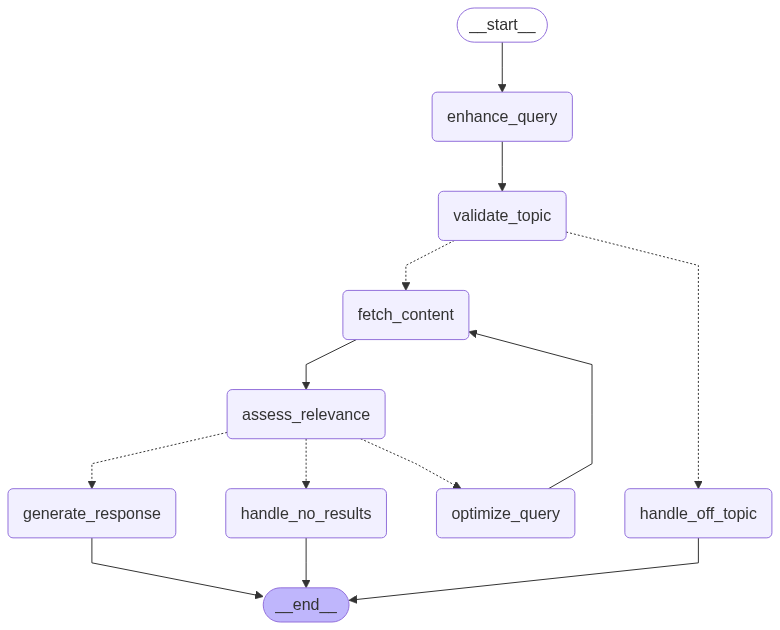

In [33]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        advanced_rag_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [34]:
print("🧪 Testing Advanced RAG Agent\n")

# Test 1: Off-topic query
print("=== Test 1: Off-Topic Query ===")
test_input = {"current_query": HumanMessage(content="What's the weather like today?")}
result = advanced_rag_agent.invoke(
    input=test_input,
    config={"configurable": {"thread_id": "test_session_1"}}
)
print(f"Response: {result['conversation_history'][-1].content}\n")

🧪 Testing Advanced RAG Agent

=== Test 1: Off-Topic Query ===
 Enhancing query: What's the weather like today?
First query - using original: What's the weather like today?
Validating topic relevance...
Topic classification: IRRELEVANT (Confidence: HIGH)
Routing based on topic relevance...
   → Routing to off-topic handler
Handling off-topic query...
Response: I'm specialized in helping with TechFlow Solutions services, pricing, and company information.
    Your question seems to be outside my area of expertise.

    I can help you with:
    - Our cloud infrastructure services and pricing
    - Support procedures and response times
    - Company information and team details
    - Security and compliance features

    Is there something specific about TechFlow Solutions I can help you with?



In [35]:
# Test 2: On-topic query about pricing
print("=== Test 2: Service Pricing Query ===")
test_input = {"current_query": HumanMessage(content="What are your support service pricing options?")}
result = advanced_rag_agent.invoke(
    input=test_input,
    config={"configurable": {"thread_id": "test_session_2"}}
)
print(f"Response: {result['conversation_history'][-1].content}\n")


=== Test 2: Service Pricing Query ===
 Enhancing query: What are your support service pricing options?
First query - using original: What are your support service pricing options?
Validating topic relevance...
Topic classification: RELEVANT (Confidence: HIGH)
Routing based on topic relevance...
   → Proceeding to content retrieval
Fetching relevant documents...
Retrieved 2 documents
   Document 1: TechFlow Solutions offers three main service tiers...
   Document 2: TechFlow Solutions offers three main service tiers...
Assessing document relevance...
📋 Document 1: RELEVANT - The document directly answers the question by listing the names, features, and prices of the support service tiers offered by TechFlow Solutions.
📋 Document 2: RELEVANT - The document directly answers the question about support service pricing options by providing the names, features, and prices of three different support tiers.
Final relevant documents: 2
Routing based on document quality...
 Generating response wi

In [36]:
# Test 3: Follow-up question in same conversation
print("=== Test 3: Follow-Up Question ===")
test_input = {"current_query": HumanMessage(content="What about the infrastructure services?")}
result = advanced_rag_agent.invoke(
    input=test_input,
    config={"configurable": {"thread_id": "test_session_2"}}  # Same session
)
print(f"Response: {result['conversation_history'][-1].content}\n")

=== Test 3: Follow-Up Question ===
 Enhancing query: What about the infrastructure services?
 Enhanced query: What are the pricing options for infrastructure services, similar to the Basic, Professional, and Enterprise support service options previously discussed?
Validating topic relevance...
Topic classification: RELEVANT (Confidence: HIGH)
Routing based on topic relevance...
   → Proceeding to content retrieval
Fetching relevant documents...
Retrieved 2 documents
   Document 1: Our cloud infrastructure services include: Virtual...
   Document 2: Our cloud infrastructure services include: Virtual...
Assessing document relevance...
📋 Document 1: RELEVANT - The document lists pricing options for cloud infrastructure services, which directly answers the question about pricing. Although it doesn't mention Basic, Professional, and Enterprise tiers, it provides specific pricing for different infrastructure services.
📋 Document 2: RELEVANT - The document lists pricing options for cloud infr

In [38]:
# Test 4: Company information query
print("=== Test 4: Company Information ===")
test_input = {"current_query": HumanMessage(content="Who founded TechFlow Solutions?")}
result = advanced_rag_agent.invoke(
    input=test_input,
    config={"configurable": {"thread_id": "test_session_3"}}
)
print(f"Response: {result['conversation_history'][-1].content}\n")


=== Test 4: Company Information ===
 Enhancing query: Who founded TechFlow Solutions?
First query - using original: Who founded TechFlow Solutions?
Validating topic relevance...
Topic classification: RELEVANT (Confidence: HIGH)
Routing based on topic relevance...
   → Proceeding to content retrieval
Fetching relevant documents...
Retrieved 2 documents
   Document 1: TechFlow Solutions was founded in 2018 by Maria Ro...
   Document 2: TechFlow Solutions was founded in 2018 by Maria Ro...
Assessing document relevance...
📋 Document 1: RELEVANT - The document directly answers the question of who founded TechFlow Solutions.
📋 Document 2: RELEVANT - The document directly answers the question of who founded TechFlow Solutions.
Final relevant documents: 2
Routing based on document quality...
 Generating response with relevant documents
Generating contextual response...
 Generated response: TechFlow Solutions was founded in 2018 by Maria Rodriguez. She is a former Google engineer with 15 y...
R

In [ ]:
# Test 5: Complex follow-up requiring context
print("=== Test 5: Context-Dependent Follow-Up ===")
test_input = {"current_query": HumanMessage(content="How does their support compare to the enterprise level?")}
result = advanced_rag_agent.invoke(
    input=test_input,
    config={"configurable": {"thread_id": "test_session_3"}}  # Same session as company info
)
print(f"Response: {result['conversation_history'][-1].content}\n")


=== Test 5: Context-Dependent Follow-Up ===
 Enhancing query: How does their support compare to the enterprise level?
